Create the bipartite network

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
import pickle
from os import listdir
from os.path import isfile, join
from collections import *

PROCESSED_PATH = "random_stock_tweets/processed/"
STOCK_PATH = "random_stock_tweets/"
USER_PATH = "random_stock_users/"


def load_stock(stock):
	with open(STOCK_PATH+stock, 'r') as f:
		return pickle.load(f)
def load_user(user):
	with open(USER_PATH+user, 'r') as f:
		return pickle.load(f)

stocks = {}
if not isfile('stock_tweets_for_graph'):
    for f in listdir(STOCK_PATH): 
        if isfile(join(STOCK_PATH,f)):
            tweets = None
            tweets = load_stock(f)
            stocks[f] = [{'author': {'id_str': tweet.author.id_str}} for tweet in tweets]
    with open('stock_tweets_for_graph', 'w') as f:
        pickle.dump(stocks, f)
else:
    with open('stock_tweets_for_graph') as f:
         stocks = pickle.load(f)

In [8]:
       

# stocks = {f: [{'author': {'id_str': tweet.author.id_str}} for tweet in load_stock(f)] for f in listdir(STOCK_PATH) if isfile(join(STOCK_PATH,f))}
users = set([f for f in listdir(USER_PATH) if isfile(join(USER_PATH, f))])

In [9]:
# Bipartite graphs in networkx are implemented using a normal graph where nodes have an attribute
# value of either 0 or 1 depending on which graph it belongs to
if not isfile('bipartite_graph'):
    G = nx.Graph()
    # Add all stocks
    G.add_nodes_from(stocks.keys(), bipartite=0)
    # Add all users
    G.add_nodes_from(users, bipartite=1)
    for (symbol, stock_tweets) in stocks.iteritems():
        # Find the users that tweeted about this stock
        user_ids = set([tweet['author']['id_str'] for tweet in stock_tweets])
        G.add_edges_from([(symbol, user) for user in user_ids if user in users])

    with open('bipartite_graph', 'w') as f:
        pickle.dump(G, f)
else:
    with open('bipartite_graph') as f:
        G = pickle.load(f)
# Create the user network from the bipartite network
stock_nodes = set(n for n,d in G.nodes(data=True) if d['bipartite']==0)
user_nodes = set(G) - stock_nodes

An interesting attribute of the user network is how many stocks each user has in common. We retain this by using a weighted network graph.

In [10]:
U = bipartite.overlap_weighted_projected_graph(G, user_nodes)

From this we can recover the giant connected component to investigate further

In [11]:
components = list(nx.connected_component_subgraphs(U))
for c in components:
    print "Elements in component: {}".format(len(c))
U_max = max(components, key=len)

Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 248
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 1
Elements in component: 

Drawing this shows a highly connected graph with several nodes connected only by a single neighbor

MemoryError: 

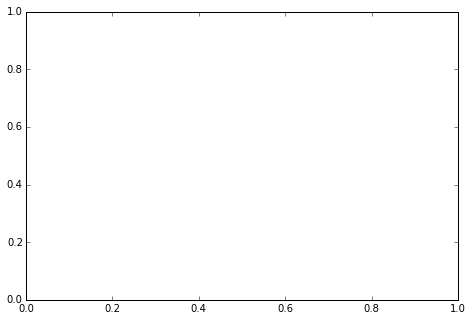

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
nx.draw(U_max, node_size = 40, figsize=(20,10))

To investigate the nature of the graph the degree distribution is plotted

In [ ]:
def plotLogDegree(graph):
    d = Counter(G.degree())
    y = Counter(d.values()).values()
    x = sorted(set(d.values()))
    plt.loglog(x,y, 'ro-') # Plot the in degree distribution
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.show()

In [ ]:
plotLogDegree(U_max)

This shows us that a lot of the nodes are single connected nodes. This is not ideal for our assumption of a network where several twitter accounts are owned by the same people and tweeting in unison.

We can now see if it's possible to find communities based on what stocks the users tweet about. Clear communities would point to twitter accounts owned by the same people.

In [7]:
import community
partition = community.best_partition(U_max)
print "Modularity for the GCC using Louvain algorithm: {}".format(community.modularity(partition, U_max))

Modularity for the GCC using Louvain algorithm: 0.841446957188


Although this shows that the algorithm is able to find commuities it is not unambiguous. The modularity being greater than 0 can also be because of hubs in the network connecting otherwise unconnected users.

In [ ]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(U_max)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(U_max, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(U_max,pos, alpha=0.5, fig_size=(20,10))

Looking at the sizes of our communities it seems they are all actually significant, all communities have double digits members.

In [8]:
partition_inv = {v:[] for v in set(partition.values())}
map(lambda tup: partition_inv[tup[1]].append(tup[0]), partition.items())
for (k,v) in partition_inv.iteritems():
    print "Partition {} has length {}".format(k,len(v))

Partition 0 has length 3704
Partition 1 has length 76
Partition 2 has length 160
Partition 3 has length 234
Partition 4 has length 228
Partition 5 has length 97
Partition 6 has length 129
Partition 7 has length 63
Partition 8 has length 220
Partition 9 has length 8
Partition 10 has length 84
Partition 11 has length 67
Partition 12 has length 289
Partition 13 has length 76
Partition 14 has length 143
Partition 15 has length 184
Partition 16 has length 190
Partition 17 has length 131
Partition 18 has length 197
Partition 19 has length 265
Partition 20 has length 135
Partition 21 has length 74
Partition 22 has length 74
Partition 23 has length 165
Partition 24 has length 146
Partition 25 has length 68
Partition 26 has length 61
Partition 27 has length 264
Partition 28 has length 65
Partition 29 has length 73
Partition 30 has length 39
Partition 31 has length 88
Partition 32 has length 28
Partition 33 has length 144
Partition 34 has length 2
Partition 35 has length 89
Partition 36 has leng

In [27]:
U_com = community.induced_graph(partition, U_max)

To figure out what characterizes each community we need to know what stocks they have in common

In [28]:
def get_common_stocks(user_ids):
    """
    Gets the stocks that a collection of users have in common and the ratio of those users that have tweeted about each stock
    """
    N = len(user_ids)*1.0
    edges = G.edges(user_ids)
    stock_count = Counter(list(zip(*edges)[1]))
    return {k: v/N for (k,v) in stock_count.iteritems()}

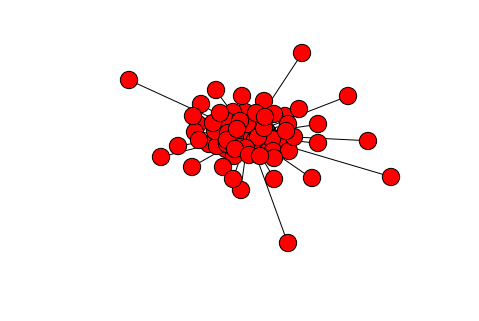

In [54]:
nx.draw(U_com)

In [58]:
get_common_stocks(partition_inv[65])

{'FTR': 0.021739130434782608,
 'GPRO': 0.32608695652173914,
 'KHC': 0.21739130434782608,
 'NWSA': 0.021739130434782608,
 'VASC': 0.021739130434782608,
 'ZN': 0.5}

To remove some noise from our network we can trim away connections between users that only shared something like a single stock. This will make sure that very popular stocks such as Apple will not influence the results, since everybody tweets about them without that meaning that the users necessarily are grouped. To find a decent cutoff weight it is a good idea to look at the distribution of weights.

In [ ]:
from collections import *
def plotWeightDistribution(G):
    c = Counter([attrib['weight'] for (node,edges) in G.edge.iteritems() for (_, attrib) in edges.iteritems()])
    x,y=zip(*[(k,c[k]) for k in sorted(c)])
    plt.loglog(x,y, 'ro') # Plot the in degree distribution
    plt.xlabel('Weight')
    plt.ylabel('Number of nodes')
    plt.show()

In [ ]:
u=Counter([attrib['weight'] for (node,edges) in U_max.edge.iteritems() for (_, attrib) in edges.iteritems()]) 
x,y=zip(*[(k,u[k]) for k in sorted(u)])

In [ ]:
plotWeightDistribution(U_max)

The almost log linear plot indicates that a large part of our edges is based on users having very few stocks in common in their tweets. We can try decimating the network by removing edges below different thresholds to investigate further.

In [ ]:
U_dec1 = U.copy()
one_neighbour_edges = [(node, edge_node) for (node,edges) in U_max.edge.iteritems() for (edge_node, attrib) in edges.iteritems() if attrib['weight'] < 2]
U_dec1.remove_edges_from(one_neighbour_edges)
components = list(nx.connected_component_subgraphs(U_dec1))
for c in components:
    if len(c) > 1:
        print "Elements in component: {}".format(len(c))
U_dec1_max = max(components, key=len)

In [ ]:
plotWeightDistribution(U_dec1_max)

In [ ]:
nx.draw(U_dec1_max, node_size=40)

In [ ]:
plotLogDegree(U_dec1_max)

In [ ]:
partition = community.best_partition(U_dec1_max)
print "Modularity for the GCC using Louvain algorithm: {}".format(community.modularity(partition, U_dec1_max))

In [ ]:
cliques=[c for c in nx.find_cliques(G)]

In [ ]:
len(cliques)